In [3]:
import geopy
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import time
import requests
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

## Загрузка координат и расстояний

In [111]:
def get_distance(coord_1, coord_2):
    link = 'https://yandex.ru/maps/213/moscow/?ll=' + str(coord_1[0]) +'%2C' + str(coord_1[1]) \
            + '&mode=routes&rtext=' + str(coord_1[0]) + '%2C' + str(coord_1[1]) \
            + '~' + str(coord_2[0]) + '%2C' + str(coord_2[1]) + '&rtm=atm&rtt=auto'
    r = requests.get(link)
    
    left = r.text.find('auto-route-snippet-view__route-subtitle')
    s = r.text[left + 40:]
    left = s.find('auto-route-snippet-view__route-subtitle')
    s = s[left + 41:]
    right = s.find('<')
    distance = float(s[:right-2].split('\xa0')[0].replace(',', '.'))
    
    left = r.text.find('auto-route-snippet-view__route-title-primary')
    s = r.text[left + 44:]
    left = s.find('auto-route-snippet-view__route-title-primary')
    s = s[left + 46:]
    right = s.find('<')
    t = s[:right].split(' ')
    if len(t) > 1:
        if '\xa0' in t[0] and '\xa0' in t[1]:
            hours = 60*float(t[0].split('\xa0')[0])
            minutes = float(t[1].split('\xa0')[0])
            time = hours + minutes
        else:
            if t[1] == 'мин':
                time = float(t[0])
            elif t[1] == 'ч':
                time = 60*float(t[0])
    else:
        if t[0].split('\xa0')[1] == 'ч':
            time = 60*float(t[0].split('\xa0')[0])
        else:
            time = float(t[0].split('\xa0')[0])
    return distance, time

In [4]:
app = Nominatim(user_agent="my-application")

In [5]:
df = pd.read_excel('./data/parsed_data/Moscow_districts.xlsx')
districts = list(df.loc[:, 'District'])

In [119]:
company_list = \
[
    'Ozon',
    'Ozon box',
    'Boxberry',
    'Wildberries',
    'Pickpoint',
    'Макдональдс',
    'KFC',
    'Burger king',
    'CDEK'
]

In [ ]:
d = {}
for company in company_list:
    d[company] = {}
    for district in districts:
        print(company, district)
        time.sleep(1)
        flag = True
        i = 1
        while flag:
            if i > 1:
                print('try number: ' + str(i))
            try:
                location = app.geocode(company + ', Москва, ' + district, exactly_one=False, limit=400)
                flag = False
            except:
                i = i + 1
        if not location is None:
            ads = list(map(lambda x: x[1], location))
        else:
            ads = []
        d[company][district] = ads

In [ ]:
company_ads = {}
for company in company_list:
    company_ads[company] = []
    for value in list(d[company].values()):
        company_ads[company] += value

In [ ]:
f = open('coords_dict.pkl', 'wb')

pickle.dump(company_ads, f)

f.close()

In [214]:
company_ads

{'Ozon': [(55.23326445, 37.112215913929916),
  (55.8447977, 37.3502353),
  (55.7889849, 37.8069101),
  (55.8662876, 37.4420419),
  (55.8238481, 37.8174037),
  (55.8507342, 37.3478991),
  (55.7847014, 37.6603823),
  (55.7423875, 37.6613742),
  (55.7288079, 37.5239825),
  (55.7693811, 37.6479779),
  (55.8535083, 37.6201174),
  (55.8441629, 37.3712114),
  (55.8485517, 37.3625533),
  (55.8804421, 37.48953),
  (55.88297, 37.4958314),
  (55.7010186, 37.8210576),
  (55.696434, 37.8097584),
  (55.7018714, 37.8405985),
  (55.626005, 37.676271),
  (55.7954253, 37.8121578),
  (55.6029384, 37.7405267),
  (55.7537992, 37.8391172),
  (55.7689768, 37.8218982),
  (55.8049713, 37.811574),
  (55.7059256, 37.6168453),
  (55.7624102, 37.7920853),
  (55.7576626, 37.7814665),
  (55.8486485, 37.6356052),
  (55.7828412, 37.5906249),
  (55.7498825, 37.8157199),
  (55.6838836, 37.7455813),
  (55.8025515, 37.5742205),
  (55.731337, 37.7177251),
  (55.7163136, 37.6605244),
  (55.8071916, 37.8185333),
  (55.625469

In [5]:
f = open('./data/parsed_data/coords_dict.pkl', 'rb')

company_ads = pickle.load(f)

f.close()

In [2]:
long_max = 56.2164
long_min = 55.2829
lat_max = 38.5774
lat_min = 36.7734

In [6]:
moscow_map = plt.imread('map.png')

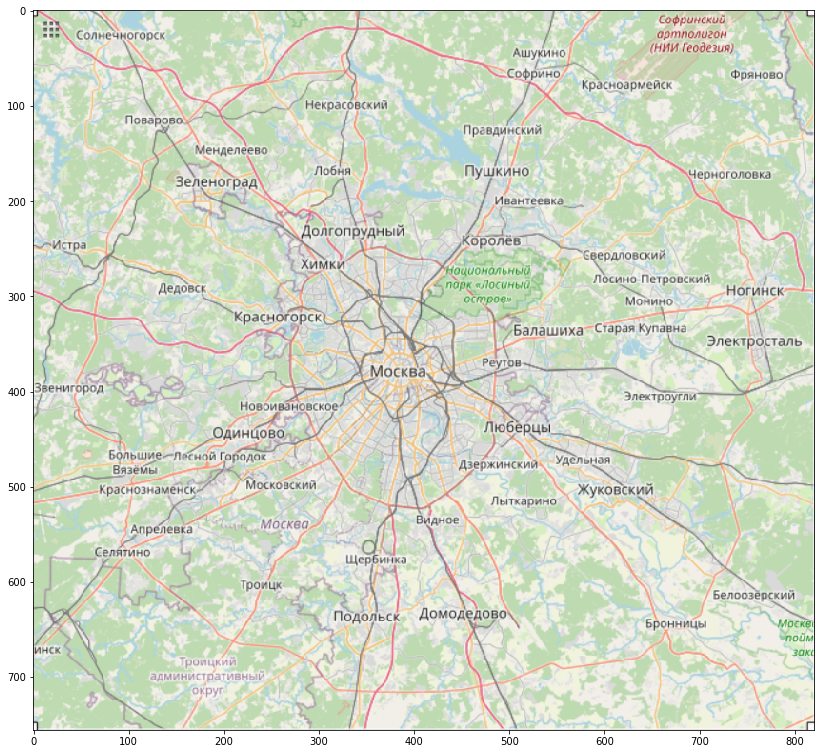

In [25]:
fig, ax = plt.subplots(figsize = (14,14))
plt.imshow(moscow_map)

In [16]:
BBox = [long_min, long_max, lat_min, lat_max]

(36.7734, 38.5774)

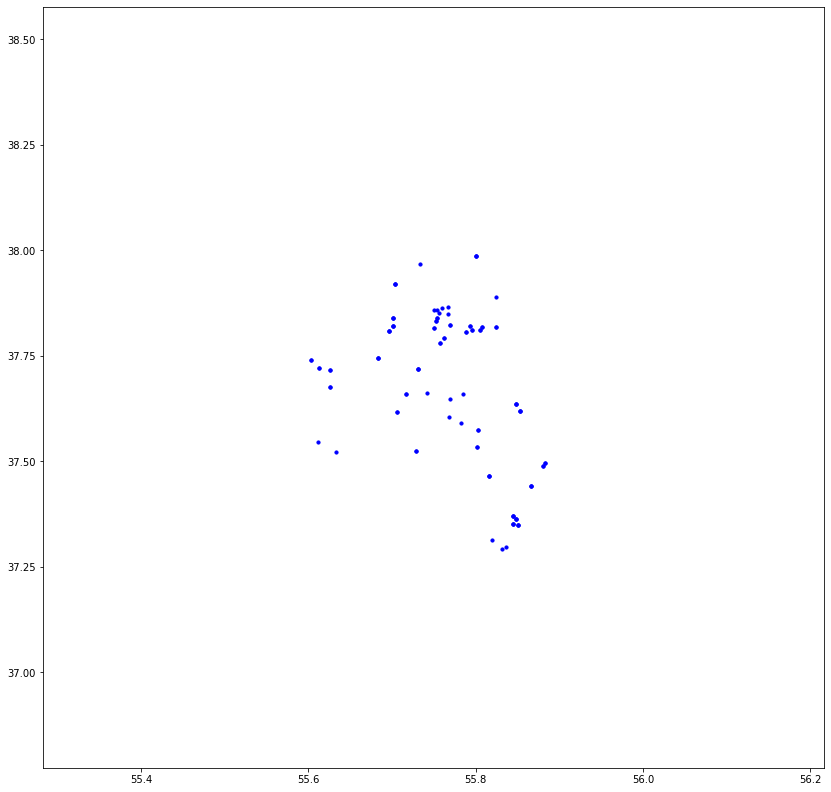

In [41]:
fig, ax = plt.subplots(figsize = (14,14))
ax.scatter(np.array(company_ads['Ozon'])[:, 0], np.array(company_ads['Ozon'])[:, 1], zorder=1, c='b', s=10)

#ax.set_title('Plotting Spatial Data on Moscow Map')
ax.set_xlim(long_min,long_max)
ax.set_ylim(lat_min,lat_max)
#plt.imshow(moscow_map, zorder=0, extent=BBox, aspect= 'equal')


In [8]:
distances = {}

In [10]:
for i in range(len(company_list)):
    distance_matrix = np.zeros((len(company_ads[company_list[i]]), 
                                len(company_ads[company_list[i]]),
                                2))
    print(company_list[i])
    for j in tqdm(range(len(list(company_ads.values())[i])), leave=False):
        for k in range(j+1, len(list(company_ads.values())[i])):
            flag = True
            m = 1
            while flag:
                if m > 1:
                    print('try number: ' + str(m))
                try:
                    time.sleep(1)
                    coord_1 = list(company_ads.values())[i][j]
                    coord_2 = list(company_ads.values())[i][k]
                    distance_matrix[j,k,0], distance_matrix[j,k,1] = get_distance(coord_1, coord_2)
                    flag = False
                except KeyboardInterrupt:
                    print(1/0)
                except:
                    m = m + 1
    distances[company_list[i]] = distance_matrix

  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

Ozon


  6%|████▉                                                                          | 7/111 [16:25<4:01:23, 139.26s/it]

try number: 2


 32%|███████████████████████▉                                                    | 35/111 [1:11:05<2:09:56, 102.58s/it]

try number: 2


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

Ozon box


  0%|                                                                                           | 0/42 [00:00<?, ?it/s]

Boxberry


  0%|                                                                                          | 0/208 [00:00<?, ?it/s]

Wildberries


  8%|██████▏                                                                    | 17/208 [1:14:14<13:35:21, 256.13s/it]

try number: 2


 38%|████████████████████████████▊                                               | 79/208 [4:47:21<5:58:37, 166.80s/it]

try number: 2


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

Pickpoint


  4%|███▎                                                                             | 3/74 [04:41<1:50:51, 93.68s/it]

try number: 2


 30%|███████████████████████▊                                                        | 22/74 [29:33<1:00:15, 69.52s/it]

try number: 2


 54%|████████████████████████████████████████████▎                                     | 40/74 [46:02<26:35, 46.94s/it]

try number: 2


  0%|                                                                                          | 0/269 [00:00<?, ?it/s]

Макдональдс
try number: 2
try number: 3
try number: 4
try number: 5
try number: 6
try number: 7
try number: 8
try number: 9
try number: 10
try number: 11
try number: 12
try number: 13
try number: 14
try number: 15
try number: 16
try number: 17
try number: 18
try number: 19
try number: 20
try number: 21
try number: 22
try number: 23
try number: 24
try number: 25
try number: 26
try number: 27
try number: 28
try number: 29
try number: 30
try number: 31
try number: 32
try number: 33
try number: 34
try number: 35
try number: 36
try number: 37
try number: 38
try number: 39
try number: 40
try number: 41
try number: 42
try number: 43
try number: 44
try number: 45
try number: 46
try number: 47
try number: 48
try number: 49
try number: 50
try number: 51
try number: 52
try number: 53
try number: 54
try number: 55
try number: 56
try number: 57
try number: 58
try number: 59
try number: 60
try number: 61
try number: 62
try number: 63
try number: 64
try number: 65
try number: 66
try number: 67
try nu

try number: 520
try number: 521
try number: 522
try number: 523
try number: 524
try number: 525
try number: 526
try number: 527
try number: 528
try number: 529
try number: 530
try number: 531
try number: 532
try number: 533
try number: 534
try number: 535
try number: 536
try number: 537
try number: 538
try number: 539
try number: 540
try number: 541
try number: 542
try number: 543
try number: 544
try number: 545
try number: 546
try number: 547
try number: 548
try number: 549
try number: 550
try number: 551
try number: 552
try number: 553
try number: 554
try number: 555
try number: 556
try number: 557
try number: 558
try number: 559
try number: 560
try number: 561
try number: 562
try number: 563
try number: 564
try number: 565
try number: 566
try number: 567
try number: 568
try number: 569
try number: 570
try number: 571
try number: 572
try number: 573
try number: 574
try number: 575
try number: 576
try number: 577
try number: 578
try number: 579
try number: 580
try number: 581
try numb

try number: 1031
try number: 1032
try number: 1033
try number: 1034
try number: 1035
try number: 1036
try number: 1037
try number: 1038
try number: 1039
try number: 1040
try number: 1041
try number: 1042
try number: 1043
try number: 1044
try number: 1045
try number: 1046
try number: 1047
try number: 1048
try number: 1049
try number: 1050
try number: 1051
try number: 1052
try number: 1053
try number: 1054
try number: 1055
try number: 1056
try number: 1057
try number: 1058
try number: 1059
try number: 1060
try number: 1061
try number: 1062
try number: 1063
try number: 1064
try number: 1065
try number: 1066
try number: 1067
try number: 1068
try number: 1069
try number: 1070
try number: 1071
try number: 1072
try number: 1073
try number: 1074
try number: 1075
try number: 1076
try number: 1077
try number: 1078
try number: 1079
try number: 1080
try number: 1081
try number: 1082
try number: 1083
try number: 1084
try number: 1085
try number: 1086
try number: 1087
try number: 1088
try number: 10

try number: 1513
try number: 1514
try number: 1515
try number: 1516
try number: 1517
try number: 1518
try number: 1519
try number: 1520
try number: 1521
try number: 1522
try number: 1523
try number: 1524
try number: 1525
try number: 1526
try number: 1527
try number: 1528
try number: 1529
try number: 1530
try number: 1531
try number: 1532
try number: 1533
try number: 1534
try number: 1535
try number: 1536
try number: 1537
try number: 1538
try number: 1539
try number: 1540
try number: 1541
try number: 1542
try number: 1543
try number: 1544
try number: 1545
try number: 1546
try number: 1547
try number: 1548
try number: 1549
try number: 1550
try number: 1551
try number: 1552
try number: 1553
try number: 1554
try number: 1555
try number: 1556
try number: 1557
try number: 1558
try number: 1559
try number: 1560
try number: 1561
try number: 1562
try number: 1563
try number: 1564
try number: 1565
try number: 1566
try number: 1567
try number: 1568
try number: 1569
try number: 1570
try number: 15

try number: 1995
try number: 1996
try number: 1997
try number: 1998
try number: 1999
try number: 2000
try number: 2001
try number: 2002
try number: 2003
try number: 2004
try number: 2005
try number: 2006
try number: 2007
try number: 2008
try number: 2009
try number: 2010
try number: 2011
try number: 2012
try number: 2013
try number: 2014
try number: 2015
try number: 2016
try number: 2017
try number: 2018
try number: 2019
try number: 2020
try number: 2021
try number: 2022
try number: 2023
try number: 2024
try number: 2025
try number: 2026
try number: 2027
try number: 2028
try number: 2029
try number: 2030
try number: 2031
try number: 2032
try number: 2033
try number: 2034
try number: 2035
try number: 2036
try number: 2037
try number: 2038
try number: 2039
try number: 2040
try number: 2041
try number: 2042
try number: 2043
try number: 2044
try number: 2045
try number: 2046
try number: 2047
try number: 2048
try number: 2049
try number: 2050
try number: 2051
try number: 2052
try number: 20

try number: 2477
try number: 2478
try number: 2479
try number: 2480
try number: 2481
try number: 2482
try number: 2483
try number: 2484
try number: 2485
try number: 2486
try number: 2487
try number: 2488
try number: 2489
try number: 2490
try number: 2491
try number: 2492
try number: 2493
try number: 2494
try number: 2495
try number: 2496
try number: 2497
try number: 2498
try number: 2499
try number: 2500
try number: 2501
try number: 2502
try number: 2503
try number: 2504
try number: 2505
try number: 2506
try number: 2507
try number: 2508
try number: 2509
try number: 2510
try number: 2511
try number: 2512
try number: 2513
try number: 2514
try number: 2515
try number: 2516
try number: 2517
try number: 2518
try number: 2519
try number: 2520
try number: 2521
try number: 2522
try number: 2523
try number: 2524
try number: 2525
try number: 2526
try number: 2527
try number: 2528
try number: 2529
try number: 2530
try number: 2531
try number: 2532
try number: 2533
try number: 2534
try number: 25

try number: 2959
try number: 2960
try number: 2961
try number: 2962
try number: 2963
try number: 2964
try number: 2965
try number: 2966
try number: 2967
try number: 2968
try number: 2969
try number: 2970
try number: 2971
try number: 2972
try number: 2973
try number: 2974
try number: 2975
try number: 2976
try number: 2977
try number: 2978
try number: 2979
try number: 2980
try number: 2981
try number: 2982
try number: 2983
try number: 2984
try number: 2985
try number: 2986
try number: 2987
try number: 2988
try number: 2989
try number: 2990
try number: 2991
try number: 2992
try number: 2993
try number: 2994
try number: 2995
try number: 2996
try number: 2997
try number: 2998
try number: 2999
try number: 3000
try number: 3001
try number: 3002
try number: 3003
try number: 3004
try number: 3005
try number: 3006
try number: 3007
try number: 3008
try number: 3009
try number: 3010
try number: 3011
try number: 3012
try number: 3013
try number: 3014
try number: 3015
try number: 3016
try number: 30

try number: 3441
try number: 3442
try number: 3443
try number: 3444
try number: 3445
try number: 3446
try number: 3447
try number: 3448
try number: 3449
try number: 3450
try number: 3451
try number: 3452
try number: 3453
try number: 3454
try number: 3455
try number: 3456
try number: 3457
try number: 3458
try number: 3459
try number: 3460
try number: 3461
try number: 3462
try number: 3463
try number: 3464
try number: 3465
try number: 3466
try number: 3467
try number: 3468
try number: 3469
try number: 3470
try number: 3471
try number: 3472
try number: 3473
try number: 3474
try number: 3475
try number: 3476
try number: 3477
try number: 3478
try number: 3479
try number: 3480
try number: 3481
try number: 3482
try number: 3483
try number: 3484
try number: 3485
try number: 3486
try number: 3487
try number: 3488
try number: 3489
try number: 3490
try number: 3491
try number: 3492
try number: 3493
try number: 3494
try number: 3495
try number: 3496
try number: 3497
try number: 3498
try number: 34

try number: 3923
try number: 3924
try number: 3925
try number: 3926
try number: 3927
try number: 3928
try number: 3929
try number: 3930
try number: 3931
try number: 3932
try number: 3933
try number: 3934
try number: 3935
try number: 3936
try number: 3937
try number: 3938
try number: 3939
try number: 3940
try number: 3941
try number: 3942
try number: 3943
try number: 3944
try number: 3945
try number: 3946
try number: 3947
try number: 3948
try number: 3949
try number: 3950
try number: 3951
try number: 3952
try number: 3953
try number: 3954
try number: 3955
try number: 3956
try number: 3957
try number: 3958
try number: 3959
try number: 3960
try number: 3961
try number: 3962
try number: 3963
try number: 3964
try number: 3965
try number: 3966
try number: 3967
try number: 3968
try number: 3969
try number: 3970
try number: 3971
try number: 3972
try number: 3973
try number: 3974
try number: 3975
try number: 3976
try number: 3977
try number: 3978
try number: 3979
try number: 3980
try number: 39

  0%|▎                                                                         | 1/269 [1:39:21<443:46:34, 5961.17s/it]

try number: 2
try number: 3
try number: 4
try number: 5
try number: 6
try number: 7
try number: 8
try number: 9
try number: 10
try number: 11
try number: 12
try number: 13
try number: 14
try number: 15
try number: 16
try number: 17
try number: 18
try number: 19
try number: 20
try number: 21
try number: 22
try number: 23
try number: 24
try number: 25
try number: 26
try number: 27
try number: 28
try number: 29
try number: 30
try number: 31
try number: 32
try number: 33
try number: 34
try number: 35
try number: 36
try number: 37
try number: 38
try number: 39
try number: 40
try number: 41
try number: 42
try number: 43
try number: 44
try number: 45
try number: 46
try number: 47
try number: 48
try number: 49
try number: 50
try number: 51
try number: 52
try number: 53
try number: 54
try number: 55
try number: 56
try number: 57
try number: 58
try number: 59
try number: 60
try number: 61
try number: 62
try number: 63
try number: 64
try number: 65
try number: 66
try number: 67
try number: 68
try

try number: 521
try number: 522
try number: 523
try number: 524
try number: 525
try number: 526
try number: 527
try number: 528
try number: 529
try number: 530
try number: 531
try number: 532
try number: 533
try number: 534
try number: 535
try number: 536
try number: 537
try number: 538
try number: 539
try number: 540
try number: 541
try number: 542
try number: 543
try number: 544
try number: 545
try number: 546
try number: 547
try number: 548
try number: 549
try number: 550
try number: 551
try number: 552
try number: 553
try number: 554
try number: 555
try number: 556
try number: 557
try number: 558
try number: 559
try number: 560
try number: 561
try number: 562
try number: 563
try number: 564
try number: 565
try number: 566
try number: 567
try number: 568
try number: 569
try number: 570
try number: 571
try number: 572
try number: 573
try number: 574
try number: 575
try number: 576
try number: 577
try number: 578
try number: 579
try number: 580
try number: 581
try number: 582
try numb

try number: 1032
try number: 1033
try number: 1034
try number: 1035
try number: 1036
try number: 1037
try number: 1038
try number: 1039
try number: 1040
try number: 1041
try number: 1042
try number: 1043
try number: 1044
try number: 1045
try number: 1046
try number: 1047
try number: 1048
try number: 1049
try number: 1050
try number: 1051
try number: 1052
try number: 1053
try number: 1054
try number: 1055
try number: 1056
try number: 1057
try number: 1058
try number: 1059
try number: 1060
try number: 1061
try number: 1062
try number: 1063
try number: 1064
try number: 1065
try number: 1066
try number: 1067
try number: 1068
try number: 1069
try number: 1070
try number: 1071
try number: 1072
try number: 1073
try number: 1074
try number: 1075
try number: 1076
try number: 1077
try number: 1078
try number: 1079
try number: 1080
try number: 1081
try number: 1082
try number: 1083
try number: 1084
try number: 1085
try number: 1086
try number: 1087
try number: 1088
try number: 1089
try number: 10

try number: 1514
try number: 1515
try number: 1516
try number: 1517
try number: 1518
try number: 1519
try number: 1520
try number: 1521
try number: 1522
try number: 1523
try number: 1524
try number: 1525
try number: 1526
try number: 1527
try number: 1528
try number: 1529
try number: 1530
try number: 1531
try number: 1532
try number: 1533
try number: 1534
try number: 1535
try number: 1536
try number: 1537
try number: 1538
try number: 1539
try number: 1540
try number: 1541
try number: 1542
try number: 1543
try number: 1544
try number: 1545
try number: 1546
try number: 1547
try number: 1548
try number: 1549
try number: 1550
try number: 1551
try number: 1552
try number: 1553
try number: 1554
try number: 1555
try number: 1556
try number: 1557
try number: 1558
try number: 1559
try number: 1560
try number: 1561
try number: 1562
try number: 1563
try number: 1564
try number: 1565
try number: 1566
try number: 1567
try number: 1568
try number: 1569
try number: 1570
try number: 1571
try number: 15

  7%|█████                                                                      | 18/269 [3:55:07<24:14:23, 347.66s/it]

try number: 2


 41%|█████████████████████████████▉                                            | 109/269 [10:39:44<9:22:58, 211.12s/it]

try number: 2


 51%|█████████████████████████████████████▉                                    | 138/269 [12:27:46<6:19:35, 173.86s/it]

try number: 2


 55%|████████████████████████████████████████▍                                 | 147/269 [12:57:15<6:50:41, 201.98s/it]

try number: 2


 68%|██████████████████████████████████████████████████▌                       | 184/269 [14:22:59<2:38:41, 112.02s/it]

try number: 2
try number: 3
try number: 4
try number: 5
try number: 6
try number: 7
try number: 8
try number: 9
try number: 10
try number: 11
try number: 12
try number: 13
try number: 14
try number: 15
try number: 16
try number: 17
try number: 18
try number: 19
try number: 20
try number: 21
try number: 22
try number: 23
try number: 24
try number: 25
try number: 26
try number: 27
try number: 28
try number: 29
try number: 30
try number: 31
try number: 32
try number: 33
try number: 34
try number: 35
try number: 36
try number: 37
try number: 38
try number: 39
try number: 40
try number: 41
try number: 42
try number: 43
try number: 44
try number: 45
try number: 46
try number: 47
try number: 48
try number: 49
try number: 50
try number: 51
try number: 52
try number: 53
try number: 54
try number: 55
try number: 56
try number: 57
try number: 58
try number: 59
try number: 60
try number: 61
try number: 62
try number: 63
try number: 64
try number: 65
try number: 66
try number: 67
try number: 68
try

try number: 521
try number: 522
try number: 523
try number: 524
try number: 525
try number: 526
try number: 527
try number: 528
try number: 529
try number: 530
try number: 531
try number: 532
try number: 533
try number: 534
try number: 535
try number: 536
try number: 537
try number: 538
try number: 539
try number: 540
try number: 541
try number: 542
try number: 543
try number: 544
try number: 545
try number: 546
try number: 547
try number: 548
try number: 549
try number: 550
try number: 551
try number: 552
try number: 553
try number: 554
try number: 555
try number: 556
try number: 557
try number: 558
try number: 559
try number: 560
try number: 561
try number: 562
try number: 563
try number: 564
try number: 565
try number: 566
try number: 567
try number: 568
try number: 569
try number: 570
try number: 571
try number: 572
try number: 573
try number: 574
try number: 575
try number: 576
try number: 577
try number: 578
try number: 579
try number: 580
try number: 581
try number: 582
try numb

try number: 1032
try number: 1033
try number: 1034
try number: 1035
try number: 1036
try number: 1037
try number: 1038
try number: 1039
try number: 1040
try number: 1041
try number: 1042
try number: 1043
try number: 1044
try number: 1045
try number: 1046
try number: 1047
try number: 1048
try number: 1049
try number: 1050
try number: 1051
try number: 1052
try number: 1053
try number: 1054
try number: 1055
try number: 1056
try number: 1057
try number: 1058
try number: 1059
try number: 1060
try number: 1061
try number: 1062
try number: 1063
try number: 1064
try number: 1065
try number: 1066
try number: 1067
try number: 1068
try number: 1069
try number: 1070
try number: 1071
try number: 1072
try number: 1073
try number: 1074
try number: 1075
try number: 1076
try number: 1077
try number: 1078
try number: 1079
try number: 1080
try number: 1081
try number: 1082
try number: 1083
try number: 1084
try number: 1085
try number: 1086
try number: 1087
try number: 1088
try number: 1089
try number: 10

  0%|                                                                                          | 0/268 [00:00<?, ?it/s]

KFC


  2%|█▋                                                                            | 6/268 [33:40<24:25:32, 335.62s/it]

try number: 2


  5%|███▉                                                                       | 14/268 [1:21:27<23:26:05, 332.15s/it]

try number: 2


  7%|█████                                                                      | 18/268 [1:42:50<22:23:08, 322.36s/it]

try number: 2
try number: 3
try number: 4
try number: 5
try number: 6
try number: 7
try number: 8
try number: 9
try number: 10
try number: 11
try number: 12
try number: 13
try number: 14
try number: 15
try number: 16
try number: 17
try number: 18
try number: 19
try number: 20
try number: 21
try number: 22
try number: 23
try number: 24
try number: 25
try number: 26
try number: 27
try number: 28
try number: 29
try number: 30
try number: 31
try number: 32
try number: 33
try number: 34
try number: 35
try number: 36
try number: 37
try number: 38
try number: 39
try number: 40
try number: 41
try number: 42
try number: 43
try number: 44
try number: 45
try number: 46
try number: 47
try number: 48
try number: 49
try number: 50
try number: 51
try number: 52
try number: 53
try number: 54
try number: 55
try number: 56
try number: 57
try number: 58
try number: 59
try number: 60
try number: 61
try number: 62
try number: 63
try number: 64
try number: 65
try number: 66
try number: 67
try number: 68


  9%|██████▉                                                                    | 25/268 [2:21:16<21:31:43, 318.95s/it]

try number: 2


 15%|██████████▉                                                                | 39/268 [3:32:39<19:13:09, 302.14s/it]

try number: 2


 19%|██████████████▌                                                            | 52/268 [4:35:05<16:56:40, 282.41s/it]

try number: 2


 25%|██████████████████▊                                                        | 67/268 [5:41:46<14:35:01, 261.20s/it]

try number: 2


 46%|██████████████████████████████████▏                                        | 122/268 [9:07:04<7:50:49, 193.49s/it]

try number: 2
try number: 2


 73%|██████████████████████████████████████████████████████▊                    | 196/268 [12:01:57<1:55:22, 96.15s/it]

try number: 2


 74%|███████████████████████████████████████████████████████▏                   | 197/268 [12:03:37<1:55:20, 97.48s/it]

try number: 2


 79%|███████████████████████████████████████████████████████████▎               | 212/268 [12:24:06<1:10:14, 75.26s/it]

try number: 2


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Burger king


 24%|█████████████████▋                                                         | 61/259 [5:04:40<14:39:15, 266.44s/it]

try number: 2


 48%|████████████████████████████████████▏                                      | 125/259 [9:13:08<7:09:48, 192.45s/it]

try number: 2


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

CDEK


In [11]:
f = open('distances.pkl', 'wb')

pickle.dump(distances, f)

f.close()

## Формирование датасетов

In [146]:
f = open('distances.pkl', 'rb')

distances = pickle.load(f)

f.close()

In [189]:
companies = list(distances.keys())
companies.remove('CDEK')

In [206]:
final_points = []
final_distances = []
for c in companies:
    n = distances[c].shape[0]
    counter = 0
    ind = []
    for i in range(n):
        if distances[c][i].max() > 200:
            counter = counter + 1
        else:
            ind.append(i)
    ind = np.array(ind)
    final_points.append(np.array(company_ads[c])[ind])
    d = distances[c][np.ix_(ind, ind)]
    for i in range(n-counter):
        for j in range(i + 1, n-counter):
            d[j][i] = d[i][j]
    final_distances.append(d)
    print(c, n - counter)

Ozon 100
Ozon box 54
Boxberry 35
Wildberries 179
Pickpoint 58
Макдональдс 234
KFC 232
Burger king 106


In [209]:
point_set = []
dists_set = []
for i in range(len(final_points)):
    r = np.arange(len(final_points[i]))
    if companies[i] == 'Boxberry':
        continue
    for t in range(T):
        ind = np.random.choice(r, size=(50,), replace=False).astype(int)
        points = final_points[i][ind]
        min_x = points[:, 0].min()
        min_y = points[:, 1].min()
        points[:, 0] = points[:, 0] - min_x
        points[:, 1] = points[:, 1] - min_y
        max_x = points[:, 0].max()
        max_y = points[:, 1].max()
        points[:, 0] = points[:, 0]/max_x
        points[:, 1] = points[:, 1]/max_y
        dists = final_distances[i][np.ix_(ind, ind)]
        point_set.append(points)
        dists_set.append(dists)

In [210]:
f = open('./data/parsed_data/dataset_50.pkl', 'wb')

pickle.dump(point_set, f)

f.close()

f = open('./data/parsed_data/dataset_dist_50.pkl', 'wb')

pickle.dump(dists_set, f)

f.close()

In [211]:
point_set = []
dists_set = []
for i in range(len(final_points)):
    r = np.arange(len(final_points[i]))
    for t in range(T):
        ind = np.random.choice(r, size=(20,), replace=False).astype(int)
        points = final_points[i][ind]
        min_x = points[:, 0].min()
        min_y = points[:, 1].min()
        points[:, 0] = points[:, 0] - min_x
        points[:, 1] = points[:, 1] - min_y
        max_x = points[:, 0].max()
        max_y = points[:, 1].max()
        points[:, 0] = points[:, 0]/max_x
        points[:, 1] = points[:, 1]/max_y
        dists = final_distances[i][np.ix_(ind, ind)]
        point_set.append(points)
        dists_set.append(dists)

In [213]:
f = open('./data/parsed_data/dataset_20.pkl', 'wb')

pickle.dump(point_set, f)

f.close()

f = open('./data/parsed_data/dataset_dist_20.pkl', 'wb')

pickle.dump(dists_set, f)

f.close()